Fit interpretable models to the training set and test on validation sets.

In [60]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle as pkl
from os.path import join as oj

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree

import imodels
from rulevetting.api import validation, util as api_util
from rulevetting.projects.csi_pecarn.dataset import Dataset
from rulevetting import DATA_PATH

MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
df_train, df_tune, df_test = Dataset().get_data()
outcome_def = 'outcome'  # output
meta_keys = api_util.get_feat_names_from_base_feats(df_train.columns, Dataset().get_meta_keys())

kwargs {'clean_data': {'include_intervention': True}, 'preprocess_data': {'unclear_feat_default': 0, 'only_site_data': False, 'use_control_type': 'all'}, 'extract_features': {'drop_negative_columns': False}}


In [62]:
X_train = df_train.drop(columns=[outcome_def, *meta_keys])
y_train = df_train[outcome_def].values
X_tune = df_tune.drop(columns=[outcome_def, *meta_keys])
y_tune = df_tune[outcome_def].values
X_test = df_test.drop(columns=[outcome_def, *meta_keys])
y_test = df_test[outcome_def].values
processed_feats = X_train.keys().values.tolist()
feature_names = processed_feats
# pd.concat((X_train, X_tune, X_test)).to_csv(oj(DATA_PATH, 'csi_pecarn/processed/csi_all.csv'))

def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x.values)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

def simple_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    print("Specificity: ", specificity)
    print("Sensitivity: ", sensitivity)

# fit simple models

**decision tree**

/Users/keyan/anaconda3/envs/rulevet/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
100%|██████████| 9/9 [00:00<00:00, 698.11it/s]
/Users/keyan/anaconda3/envs/rulevet/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
100%|██████████| 9/9 [00:00<00:00, 1430.42it/s]


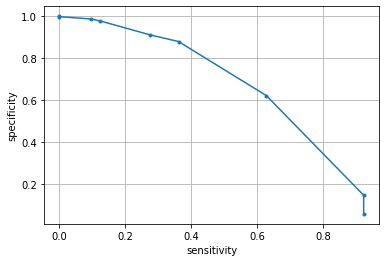

<Figure size 3600x2880 with 0 Axes>

In [63]:
# fit decition tree
dt = DecisionTreeClassifier(max_depth=5, class_weight={0: 1, 1: 1000})
dt.fit(X_train, y_train)
stats, threshes = predict_and_save(dt, model_name='decision_tree')
# plt.xlim((0.8, 1.0))
# plt.ylim((0.5, 1.0))
plt.show()

fig = plt.figure(figsize=(50, 40))
# plot_tree(dt, feature_names=feature_names, filled=True)
plt.show()

**rulefit**

100%|██████████| 39/39 [00:00<00:00, 2479.02it/s]


'\ndef print_best(sens, spec):\n    idxs = np.array(sens) > 0.9\n    print(np.array(sens)[idxs], np.array(spec)[idxs])\nprint_best(sens, spec)\n'

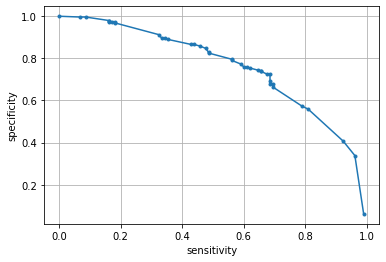

In [64]:
# fit a rulefit model
np.random.seed(13)
rulefit = imodels.RuleFitClassifier(alpha=20, max_rules=None, random_state=0, tree_size=3, n_estimators=50)
rulefit.fit(X_train, y_train, feature_names=feature_names)

# preds = rulefit.predict(X_test)
stats, threshes = predict_and_save(rulefit, model_name='rulefit')
'''
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
'''

In [65]:
# pd.reset_option('display.max_colwidth')
rulefit.visualize()

,rule,coef
14,PainNeck2,0.49
29,Immobilization2,0.02
40,HighriskDiving <= 0.5 and MedsRecd2 <= 0.5,-0.32
42,HighriskDiving <= 0.5 and MedsRecd2 <= 0.5,-0.01
38,FocalNeuroFindings2 <= 0.5 and Torticollis2 <= 0.5,-0.67
39,FocalNeuroFindings2 <= 0.5 and Torticollis2 <= 0.5,-0.51
41,subinj_TorsoTrunk2 <= 0.5 and MedsRecd2 <= 0.5,-0.60
37,FocalNeuroFindings2 <= 0.5 and Torticollis2 <= 0.5 and MedsRecd2 <= 0.5,-0.05
36,AlteredMentalStatus2 <= 0.5 and FocalNeuroFindings2 <= 0.5,-0.58


### original CDR

In [66]:
def baseline_cdr_predict(X, use_2 = False):
    num_conditions = (X['AlteredMentalStatus2'] + 
                      X['FocalNeuroFindings2'] + 
                      X['PainNeck2'] +
                      X['Torticollis2'] + 
                      X['subinj_TorsoTrunk2'] + 
                      X['Predisposed'] + 
                      X['HighriskDiving'] + 
                      X['HighriskMVC'])
    preds = (num_conditions > 0).astype(int).values
    return preds

In [67]:
X_all = pd.concat((X_train, X_tune, X_test))
y_all = np.concatenate((y_train, y_tune, y_test), axis=0)

In [68]:
simple_report(y_train, baseline_cdr_predict(X_train))

              precision    recall  f1-score   support

           0       0.99      0.31      0.47      1609
           1       0.22      0.98      0.36       317

    accuracy                           0.42      1926
   macro avg       0.60      0.64      0.41      1926
weighted avg       0.86      0.42      0.45      1926

Specificity:  0.3107520198881293
Sensitivity:  0.9779179810725552


In [69]:
print(simple_report(y_tune, baseline_cdr_predict(X_tune)))

              precision    recall  f1-score   support

           0       0.98      0.32      0.48       538
           1       0.22      0.96      0.35       105

    accuracy                           0.42       643
   macro avg       0.60      0.64      0.42       643
weighted avg       0.85      0.42      0.46       643

Specificity:  0.31784386617100374
Sensitivity:  0.9619047619047619
None


## skope

100%|██████████| 75/75 [00:00<00:00, 2200.64it/s]


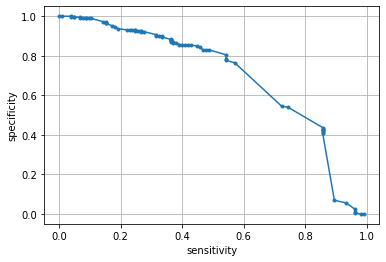

In [70]:
skope = imodels.SkopeRulesClassifier(precision_min=0.01, recall_min=0.1, n_estimators=10, max_samples=0.8, bootstrap=True, max_depth=3, random_state=0)
skope.fit(X_train, y_train)
stats, threshes = predict_and_save(skope, model_name='skope')

In [71]:
len(skope.rules_)

28

100%|██████████| 35/35 [00:00<00:00, 1984.68it/s]


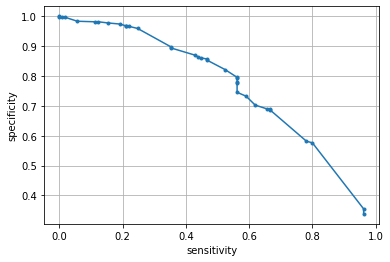

In [72]:
boost = imodels.BoostedRulesClassifier(n_estimators=10,)
boost.fit(X_train, y_train)
stats, threshes = predict_and_save(boost, model_name='boostedrules')

In [73]:
[(r, w) for r, w in boost.rules_]

[('X_14 <= 0.5', [-0.6305299569811361]),
 ('X_14 > 0.5', [-0.04335764341054425]),
 ('X_14 <= 0.5', [-0.07485046644365428]),
 ('X_14 > 0.5', [0.2177965458629978]),
 ('X_31 <= 0.5', [0.004082025603870702]),
 ('X_31 > 0.5', [0.1055688469774294]),
 ('X_31 <= 0.5', [-0.03738501707970182]),
 ('X_31 > 0.5', [0.10701456248321017]),
 ('X_15 <= 0.5', [-0.018712358814146214]),
 ('X_15 > 0.5', [0.07097154451194186]),
 ('X_13 <= 0.5', [0.0006502857433463686]),
 ('X_13 > 0.5', [0.05283580687064031]),
 ('X_13 <= 0.5', [-0.021820275959806467]),
 ('X_13 > 0.5', [0.05192435175459347]),
 ('X_18 <= 0.5', [0.0002870088376575227]),
 ('X_18 > 0.5', [0.04200314926598627]),
 ('X_18 <= 0.5', [-0.008573431814159555]),
 ('X_18 > 0.5', [0.06403034162315369]),
 ('X_22 <= 0.5', [0.004768853538042113]),
 ('X_22 > 0.5', [0.04612457443332552])]

100%|██████████| 77/77 [00:00<00:00, 2087.89it/s]


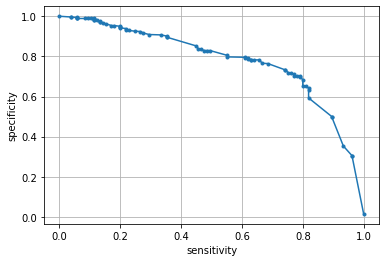

In [74]:
saps = imodels.SaplingSumClassifier(max_rules=20)
saps.fit(X_train.values, y_train, feature_names=feature_names)
stats, threshes = predict_and_save(saps, model_name='saps')

In [75]:
print(saps)

------------
FocalNeuroFindings2 <= 0.500 (Tree #0 root)
	Torticollis2 <= 0.500 (split)
		Val: 0.098 (leaf)
		Immobilization2 <= 0.500 (split)
			Val: 0.233 (leaf)
			age_preschool <= 0.500 (split)
				Val: 0.349 (leaf)
				Val: 0.678 (leaf)
	HighriskMVC <= 0.500 (split)
		Val: 0.521 (leaf)
		Val: 0.303 (leaf)

	+
MedsRecd2 <= 0.500 (Tree #1 root)
	FocalNeuroFindings2 <= 0.500 (split)
		HighriskMVC <= 0.500 (split)
			Val: -0.031 (leaf)
			Position_IDEMS <= 0.500 (split)
				Val: 0.036 (leaf)
				Val: 0.289 (leaf)
		Val: -0.119 (leaf)
	PainNeck2 <= 0.500 (split)
		Val: 0.062 (leaf)
		Immobilization2 <= 0.500 (split)
			Val: 0.092 (leaf)
			Val: 0.326 (leaf)

	+
HighriskDiving <= 0.500 (Tree #2 root)
	Predisposed <= 0.500 (split)
		subinj_TorsoTrunk2 <= 0.500 (split)
			AlteredMentalStatus2 <= 0.500 (split)
				Val: -0.034 (leaf)
				Val: 0.027 (leaf)
			AlteredMentalStatus2 <= 0.500 (split)
				Val: -0.051 (leaf)
				AxialLoadAnyDoc <= 0.500 (split)
					Val: 0.345 (leaf)
					Val: -0.

In [76]:
stats['spec'][1], stats['sens'][1]

(0.30297397769516726, 0.9619047619047619)

## neural net

In [77]:
from sklearn.neural_network import MLPClassifier

/Users/keyan/anaconda3/envs/rulevet/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/keyan/anaconda3/envs/rulevet/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
100%|██████████| 1659/1659 [00:00<00:00, 1754.78it/s]
/Users/keyan/anaconda3/envs/rulevet/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
100%|██████████| 613/613 [00:00<00:00, 2378.68it/s]


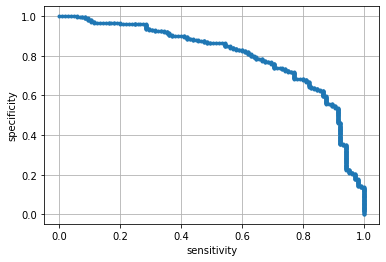

In [78]:
nn = MLPClassifier(hidden_layer_sizes=(100, ))
nn.fit(X_train, y_train)
stats, threshes = predict_and_save(nn, model_name='nn')

**CORELS**

100%|██████████| 2/2 [00:00<00:00, 485.79it/s]

OptimalRuleList:

   317 / 1926 (positive class / total)
	↓ 
If FocalNeuroFindings2                 → 133 /  281 (47.3%)
	↓ 
   184 /  1645	 
	↓ 
If FocalNeuroFindings2  & MedsRecd2    →   0 /    0 (0.0%)
	↓ 
   184 /  1645	 



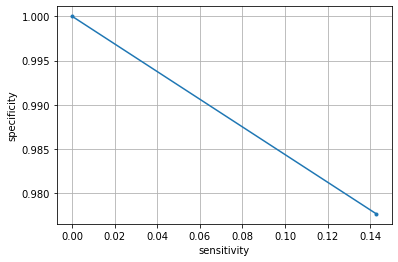

In [83]:
corels = imodels.OptimalRuleListClassifier(
    c=0.001, n_iter=100000, map_type="prefix", policy="curious", verbosity=[], ablation=0, max_card=2, min_support=0.01, random_state=0)
corels.fit(X_train, y_train, feature_names=feature_names)
stats, threshes = predict_and_save(corels, model_name='corels')
print(corels)

### Stablerules

In [84]:
from imodels.experimental import stablelinear

In [85]:
weak_learners = [rulefit, skope, boost]

In [86]:
stbl = stablelinear.StableLinearClassifier(weak_learners=weak_learners, max_complexity=-1, alpha=0.1, max_rules=None, penalty='l1')
stbl.fit(X_train, y_train)

StableLinearClassifier(alpha=0.1, max_complexity=-1, max_rules=None,
                       weak_learners=[RuleFitClassifier(alpha=20,
                                                        max_rules=None,
                                                        n_estimators=50,
                                                        random_state=0,
                                                        tree_size=3),
                                      SkopeRulesClassifier(bootstrap=True,
                                                           precision_min=0.01,
                                                           random_state=0,
                                                           recall_min=0.1),
                                      BoostedRulesClassifier()])

100%|██████████| 88/88 [00:00<00:00, 2017.61it/s]


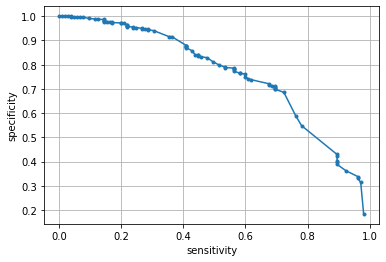

In [87]:
stats, threshes = predict_and_save(stbl, model_name='stbl')

In [88]:
stbl.rules_

[FocalNeuroFindings2 > 0.5,
 gender_F > 0.5,
 HighriskDiving <= 0.5 and MedsRecd2 <= 0.5,
 FocalNeuroFindings2 <= 0.5 and Torticollis2 <= 0.5,
 subinj_TorsoTrunk2 <= 0.5,
 Torticollis2 <= 0.5,
 AlteredMentalStatus2 <= 0.5,
 MedsRecd2 <= 0.5,
 subinj_Head2 > 0.5,
 PainNeck2 > 0.5,
 HighriskDiving <= 0.5,
 FocalNeuroFindings2 <= 0.5 and MedsRecd2 <= 0.5 and Torticollis2 <= 0.5]

In [92]:
stats['sens'][1], stats['spec'][1]

(0.9714285714285714, 0.3141263940520446)

# look at all the results

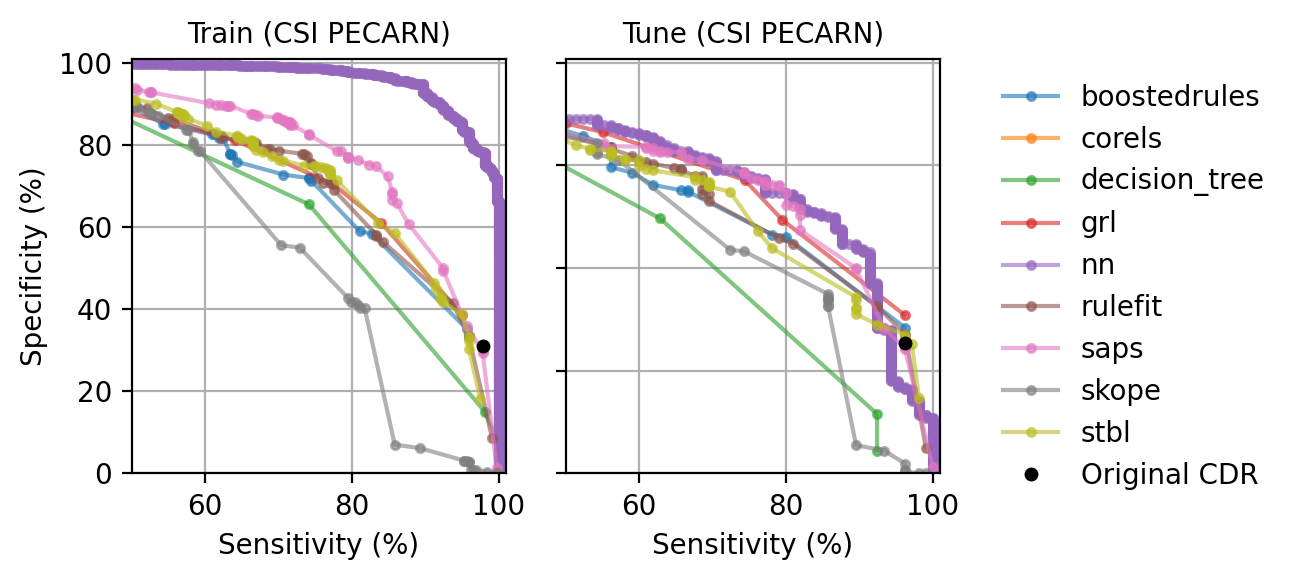

In [94]:
def plot_metrics(suffix, title=None, fs=15):
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                #         print(r)
                #                 print(r.keys())

                threshes = np.array(r['threshes' + suffix])
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                plt.plot(100 * sens, 100 * spec, 'o-', label=fname[:-4], alpha=0.6, markersize=3)
                plt.xlabel('Sensitivity (%)', fontsize=fs)
                plt.ylabel('Specificity (%)', fontsize=fs)
                s = suffix[1:]
                if title is None:
                    plt.title(f'{s}\n{data_sizes[s][0]} IAI-I / {data_sizes[s][1]}')
                else:
                    plt.title(title, fontsize=fs)

                # print best results
                if suffix == '_test2':
                    idxs = (sens > 0.95) & (spec > 0.43)
                    if np.sum(idxs) > 0:
                        idx_max = np.argmax(spec[idxs])
                        print(fname, f'{100 * sens[idxs][idx_max]:0.2f} {100 * spec[idxs][idx_max]:0.2f}')

    if suffix == '_train':
        plt.plot(97.79, 31.05, 'o', color='black', label='Original CDR', ms=4)
    if suffix == '_tune':
        plt.plot(96.19, 31.78, 'o', color='black', label='Original CDR', ms=4)
    plt.grid()


suffixes = ['_train', '_tune']  # _train, _test1, _test2, _cv
titles = ['Train (CSI PECARN)', 'Tune (CSI PECARN)']
R, C = 1, len(suffixes)
plt.figure(dpi=200, figsize=(C * 2.5, R * 3), facecolor='w')
fs = 10
for i, suffix in enumerate(suffixes):
    ax = plt.subplot(R, C, i + 1)
    plot_metrics(suffix, title=titles[i], fs=fs)
    if i > 0:
        plt.ylabel('')
        plt.yticks([0, 25, 50, 75, 100], labels=[''] * 5)
    #         ax.yaxis.set_visible(False)
    plt.xlim((50, 101))
    plt.ylim((0, 101))
plt.tight_layout()
# plt.subplot(R, C, 1)
# plt.legend(fontsize=20)
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=fs, frameon=False)
#plt.savefig('figs/metrics_3_splits')
plt.show()